In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
cd ~/bmi_dynamics_code/

/Users/preeyakhanna/bmi_dynamics_code


In [18]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns

import ssm
from ssm.util import random_rotation

from online_analysis import generate_models, util_fcns

In [3]:
# Simulate the nascar data
def make_nascar_model(D_latent, D_obs, K):
    As = [random_rotation(D_latent, np.pi/24.),
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))

    true_rslds = ssm.SLDS(D_obs, K, D_latent,
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))

    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r

    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds



In [54]:
#init, trans, dyn, em = true_rslds.params

In [62]:
#z, x, y = true_rslds.sample()

In [14]:
nTrls = 100
T = 30
true_rslds = make_nascar_model(2, 10, 4)

trls = []; 
trls_held_out = []; 

for _ in range(nTrls): 
    _, _, y2 = true_rslds.sample(T=T)
    _, _, y = true_rslds.sample(T=T)
    trls.append(y)
    trls_held_out.append(y2)
    

In [16]:
### See if 'approx_variational' posterior actually updates / fits the posterior 
rslds_lem = ssm.SLDS(10, 4, 2,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)

# # Initialize the model with the observed data.  It is important
# # to call this before constructing the variational posterior since
# # the posterior constructor initialization looks at the rSLDS parameters.
rslds_lem.initialize(trls)

q_elbos_lem, q_lem = rslds_lem.fit(trls, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=50, alpha=0.0)

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, ' ELBOS')

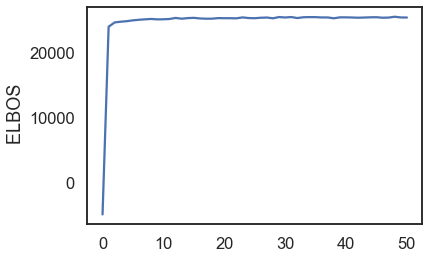

In [28]:
f, ax = plt.subplots()
ax.plot(q_elbos_lem)
ax.set_ylabel(" ELBOS")

In [26]:
## Subselect 10 trials ## 
trls_held_out2 = []
for it, t in enumerate(trls_held_out): 
    if it < 10: 
        trls_held_out2.append(t)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

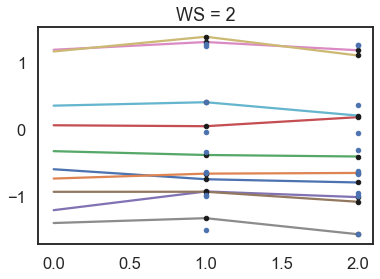

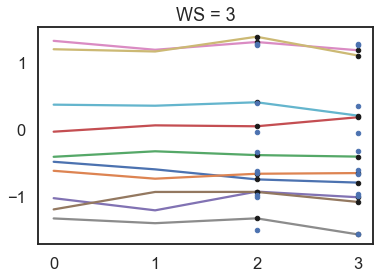

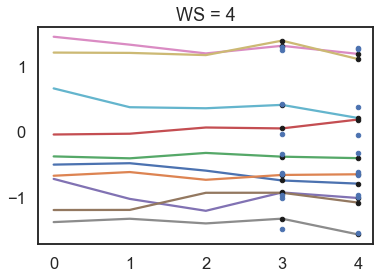

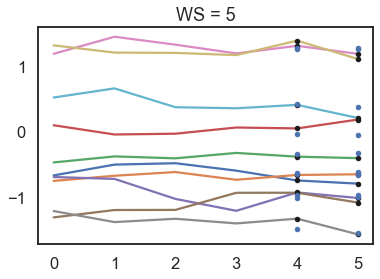

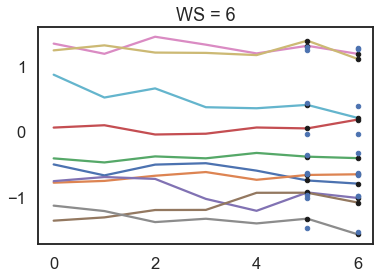

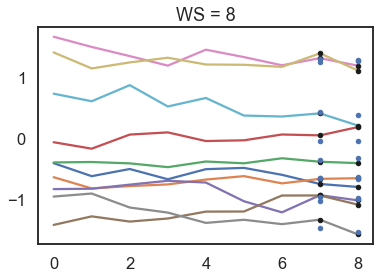

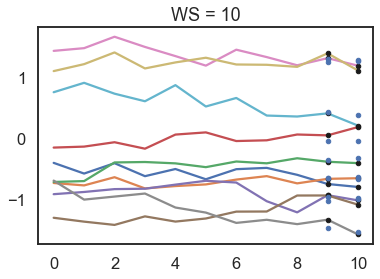

In [75]:
window_size = [2, 3, 4, 5, 6, 8, 10]#, 10, 20]
window_size_max = 10; 
nit_post = 5; 
ws_r2 = {}

for i_w, ws in enumerate(window_size): 

    ### Get test data w/ different window sizes ###
    pts_post, pts_true_test, pts_true_test_tm1 = get_slds_data_test(trls_held_out2, ws, window_size_max)

    ### get held out data prediction ###
    xhat_post = generate_models.fit_slds_posteriors(rslds_lem, pts_post, nit_post)

    ### maek sure shapes match ###
    for ix, x in enumerate(xhat_post): 
        assert(x.shape[0] == pts_post[ix].shape[0])
    
    ### predict it forward
    yt_pred_all = generate_models.pred_fwd_slds(rslds_lem, xhat_post)

    ### going forward ### 
    r2_fwd = util_fcns.get_R2(np.vstack((pts_true_test)), np.vstack((yt_pred_all)))
    ws_r2[ws, 'r2_pred'] = r2_fwd

    ### smoothed ###
    yt_pred_tm1 = generate_models.pred_tm1_slds(rslds_lem, xhat_post)
    r2_smooth = util_fcns.get_R2(np.vstack((pts_true_test_tm1)), np.vstack((yt_pred_tm1)))

    ws_r2[ws, 'r2_smooth'] = r2_smooth
    
    ### Trial 1
    ### Plot true ###
    f, ax = plt.subplots()
    ax.plot(np.vstack((pts_post[0], pts_true_test[0] )))
    ax.plot(np.zeros((10,))+ws, pts_true_test[0], 'k.')
    ax.plot(np.zeros((10,))+ws-1, pts_true_test_tm1[0], 'k.')

    ### Plot estimated ###
    ax.plot(np.zeros((10, ))+ws, yt_pred_all[0], 'b.')
    ax.plot(np.zeros((10, ))+ws-1, yt_pred_tm1[0], 'b.')
    ax.set_title('WS = %d'%ws)

90

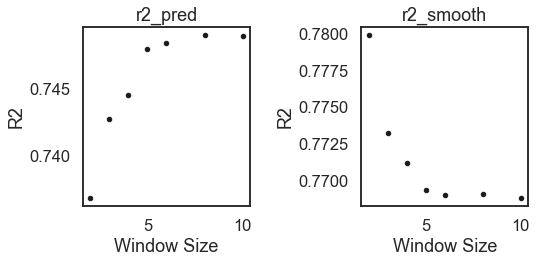

In [77]:
f, ax = plt.subplots(ncols = 2, figsize=(8, 4))
for ir, r2_ in enumerate(['r2_pred', 'r2_smooth']): 
    for ws in window_size: 
        ax[ir].plot(ws, ws_r2[ws, r2_], 'k.')
    ax[ir].set_title(r2_)
    ax[ir].set_xlabel('Window Size')
    ax[ir].set_ylabel('R2')
f.tight_layout()

In [33]:
#pts_post, pts_true_test, pts_true_test_tm1

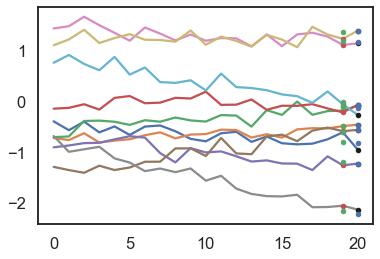

In [53]:
### Plot true ###
plt.plot(np.vstack((pts_post[0], pts_true_test[0] )))
plt.plot(np.zeros((10,))+20, pts_true_test[0], 'k.')
plt.plot(np.zeros((10,))+20-1, pts_true_test_tm1[0], 'r.')

### Plot estimated ###
plt.plot(np.zeros((10, ))+20, yt_pred_all[0], 'b.')
plt.plot(np.zeros((10, ))+20-1, yt_pred_tm1[0], 'g.')

In [70]:
def get_slds_data_test(y_test, window_size, window_size_max): 
    pts_post = []; 
    pts_true_test = []; 
    pts_true_test_tm1 = []; 
    
    for trl in y_test: 
        nT = trl.shape[0]
        
        for t in range(window_size_max, nT - 1):
            tmp = trl[t-window_size:t, :]
            pts_post.append(tmp)
            
            pts_true_test.append(trl[t, :])
            
            ### make sure this matches the last datapoint ###
            assert(np.all(tmp[-1, :] == trl[t-1, :]))
            pts_true_test_tm1.append(trl[t-1, :])
            
    return pts_post, pts_true_test, pts_true_test_tm1
    